In [2]:
import os

from tqdm import tqdm
import numpy as np
import geopandas as gpd
import utm
import rioxarray
from pyproj import CRS
import rasterio
from shapely.geometry import Polygon
from shapely.ops import unary_union

import rasterio
from rasterio.windows import Window


In [3]:
ortho_root = "/home/quantum/Projects/VisNavigate/data/Satellite/OpenDroneMap"
ortho_raws = os.path.join(ortho_root, "raw")
ortho_basemaps = os.path.join(ortho_root, "basemaps")
ortho_tiles = os.path.join(ortho_root, "ortho_tiles")


In [4]:
GEOTIF_EXT='.jp2'
UTM_SUFFIX = 'utm'
WGS = "EPSG:4326"
VERBOSE = False


def get_raster_aoi(tif_file):
    with rasterio.open(tif_file) as src:
        crs = src.crs
        bounds = src.bounds  # Get the bounding box of the raster

    polygon = Polygon([
        (bounds.left, bounds.bottom),
        (bounds.right, bounds.bottom),
        (bounds.right, bounds.top),
        (bounds.left, bounds.top)
    ])

    gdf = gpd.GeoDataFrame({'geometry': [polygon]}, crs=crs)
    return gdf


In [5]:
import numpy as np
from scipy import ndimage
import rasterio
import cv2

def downsample_upsample(image):
    downsampled_image = ndimage.zoom(image, (1/8, 1/8), order=0)
    blurred_image = ndimage.gaussian_filter(downsampled_image, sigma=1)
    upsampled_image = ndimage.zoom(blurred_image, (8, 8), order=0)
    return upsampled_image

def get_nonzero_polygon(tif_file):
    with rasterio.open(tif_file) as src:
        windows = [window for _, window in src.block_windows()]
        crs = src.crs
        transform = src.transform

        window = Window(0, 0, 256, 256)  # edge is always zero, just check if nonzero walues swapped to 255
        data = src.read(window=window, out_shape=(src.count, window.height, window.width))
        alpha_band = np.amax(data, 0)
        nonzero_255 = np.median(alpha_band) > 128

        polygons = []
        if VERBOSE:
            windows = tqdm(windows[:])

        for window in windows:
            data = src.read(window=window, out_shape=(src.count, window.height, window.width))

            alpha_band = np.amax(data, 0)

            orig_size = alpha_band.shape[1]
            alpha_band = cv2.resize(alpha_band, (32, 32))
            zoom = orig_size/32
            window_transform = rasterio.windows.transform(window, transform)
            window_transform = window_transform * rasterio.Affine.scale(zoom, zoom)

            if nonzero_255:
                alpha_band[alpha_band>251] = 0
            alpha_band[alpha_band>0]=1
            alpha_band[alpha_band<1]=0

            if data.max() > 0:
                alpha_band = rasterio.features.sieve(alpha_band, 32, connectivity=4)
                polys = rasterio.features.shapes(alpha_band, mask=None, connectivity=4, transform=window_transform)

                polys = [Polygon(coords['coordinates'][0]) for coords, val in polys if val>0]
                if len(polys) ==0:
                    continue

                if len(polys) == 1:
                    buffer_size = np.sqrt(polys[0].area)*0.1
                    polygons.append(polys[0].buffer(buffer_size))
                    continue
                poly_max = np.max([p.area for p in polys])

                polys = [p.buffer(buffer_size) for p in polys if p.area == poly_max]
                if len(polys) > 0:
                    polygons.extend(polys)

    polygons =[unary_union(polygons)]
    gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
    return gdf


In [6]:
from shapely.geometry import Polygon
from tqdm import tqdm

def inrange(val, start, stop):
    return start <= val <= stop

def inranges(x, y, rangesx, rangesy):
    for rx, ry in zip(reversed(rangesx), reversed(rangesy)):  # last is most probable
            if inrange(x, *rx) and inrange(y, *ry):
                return True
    return False

def split_polygon_by_grid(polygon: Polygon, reference_polygon: Polygon, window_width, window_height, *, grid_shift, after_check_skip_ratio=0.):
    """
        after_check_skip_ratio (float, optional): ratio of widths and heights to skip near added cell. from cell center
    """
    minx, miny, maxx, maxy = polygon.bounds

    x_values = range(int(minx), int(maxx), grid_shift)
    y_values = range(int(miny), int(maxy), grid_shift)
    if VERBOSE:
        x_values = tqdm(x_values)

    grid_polygons = []
    skip_ranges_x = []
    skip_ranges_y = []
    for x in x_values:
        for y in y_values:
            skip_this_iter = inranges(x, y, skip_ranges_x,skip_ranges_y)
            if skip_this_iter:
                continue

            grid_polygon = Polygon([
                (x, y),
                (x + window_width, y),
                (x + window_width, y + window_height),
                (x, y + window_height),
                (x, y)
            ])
            if after_check_skip_ratio > 0:
                if reference_polygon.contains(grid_polygon):
                    grid_polygons.append(grid_polygon)
                    xc = x + window_width/2
                    yc = y + window_height/2
                    skip_dist_x = (xc - window_width * after_check_skip_ratio - window_width,
                    xc + window_width * after_check_skip_ratio)
                    skip_dist_y = (yc - window_height * after_check_skip_ratio - window_height,
                    yc + window_height * after_check_skip_ratio)
                    skip_ranges_x.append(skip_dist_x)
                    skip_ranges_y.append(skip_dist_y)
            else:
                if reference_polygon.contains(grid_polygon):
                    grid_polygons.append(grid_polygon)

    return grid_polygons


In [7]:
def poly_to_utm(poly_gdf):
    poly = poly_gdf.iloc[0]['geometry']
    lon, lat = np.array(poly.centroid.coords).squeeze()
    _, _, utm_number, utm_letter = utm.from_latlon(latitude=lat, longitude=lon)
    utm_crs = CRS.from_dict({"proj": "utm", "zone": utm_number, "south": utm_letter not in "XWVUTSRQPN"})
    return poly_gdf.to_crs(utm_crs)


In [27]:
ortho_filenames = os.listdir(ortho_raws)
# ortho_filenames = ['0221_oam_2020-06-14.tif', '0224_oam_2020-11-20.tif', '0018_oam_2021-09-08.tif']
# ortho_filenames = ['0018_oam_2021-09-08.tif']
ortho_filenames = ['0002_oam_2021-07-25.tif']


len(ortho_filenames)


1

In [28]:
aois = []
VERBOSE = True
for filename in ortho_filenames:
    ortho_path = os.path.join(ortho_raws, filename)
    aoi = get_raster_aoi(ortho_path)
    nonzero_aoi = get_nonzero_polygon(ortho_path)
    # nonzero_aoi = None
    aois.append((filename, aoi, nonzero_aoi))
    # nonzero_aoi.to_file(f'oam_nonzero-{filename}.geojson', driver="GeoJSON")


100%|██████████| 7565/7565 [01:00<00:00, 124.86it/s]


In [29]:
len(nonzero_aoi.iloc[0]['geometry'])


TypeError: object of type 'Polygon' has no len()

In [30]:
type(aois[0][1].iloc[0]['geometry']), type(aois[0][2].iloc[0]['geometry'])


(shapely.geometry.polygon.Polygon, shapely.geometry.polygon.Polygon)

In [31]:
(aois[0][1].iloc[0]['geometry']).contains(aois[0][2].iloc[0]['geometry']), (aois[0][2].iloc[0]['geometry']).contains(aois[0][1].iloc[0]['geometry'])


(False, False)

In [84]:
polys_files = []
windows_widths = [140, 280, 500, 800]
for window_w in windows_widths:

    # window_w = 140  # 100 m alt
    window_h = int(window_w/320*240)

    for filename, aoi, nonzero_aoi in tqdm(aois, desc=f"Window {window_w}"):
        if nonzero_aoi.crs == 'EPSG:4326':
            nonzero_polygon = poly_to_utm(nonzero_aoi)['geometry'].iloc[0].simplify(30)
        else:
            nonzero_polygon = nonzero_aoi['geometry'].iloc[0].simplify(30)
        if aoi.crs == 'EPSG:4326':
            aoi_polygon = poly_to_utm(aoi)
            aoi_crs = aoi_polygon.crs
            aoi_polygon = aoi_polygon['geometry'].iloc[0]
        else:
            aoi_polygon = aoi['geometry'].iloc[0]
            aoi_crs = aoi.crs

        polygons_inside = split_polygon_by_grid(aoi_polygon, nonzero_polygon, window_w, window_h, grid_shift=int(window_h/10), after_check_skip_ratio=0.3)

        gdf_inside = gpd.GeoDataFrame({'geometry': polygons_inside}, crs=aoi_crs)
        gdf_inside.to_crs('EPSG:4326', inplace=True)

        tile_size_pref = f"tilewidth-{window_w}"

        # gdf_inside['filename'] = filename
        # gdf_inside['tile_name'] =  [tile_size_pref+f"-tilenum-{i}" for i in range(len(gdf_inside['geometry']))]
        polys_files.extend(
           [filename, tile_size_pref+f"-tilenum-{i}", p] for i, p in enumerate(gdf_inside['geometry'])
        )


Window 800: 100%|██████████| 1/1 [00:00<00:00,  4.09it/s]


#### download planet

In [23]:
import mercantile
import geopandas as gpd
import os
import urllib.request
import time
from tqdm import tqdm
import cv2
import rasterio
import numpy as np
from rasterio import Affine
from shapely.geometry import Point
import math
import argparse
RESOLUTION = 3.1
TILE_SIZE = 256


def convert_wgs_to_utm(lon, lat):
    utm_band = '{:02d}'.format(math.floor((lon + 180) / 6) % 60 + 1)
    crs = 'epsg:326' + utm_band if lat >= 0 else 'epsg:327' + utm_band
    return crs


def get_lon_lat(xtile, ytile, zoom):
    Z2 = math.pow(2, zoom)
    lon_deg = xtile / Z2 * 360.0 - 180.0
    lat_rad = math.atan(math.sinh(math.pi * (1 - 2 * ytile / Z2)))
    lat_deg = math.degrees(lat_rad)
    return lon_deg, lat_deg


def convert_point(x, y, crs):
    lon, lat = get_lon_lat(x, y, 15)
    point = gpd.GeoDataFrame(geometry=[Point((lon, lat))])
    point = point.set_crs(epsg='4326')
    # point = point.to_crs(epsg=crs.split(":")[1])
    return point


class TileDownloader:
    def __init__(self, api_key, month, year, save_dir, tiles_dir=None):
        self.api_key = api_key
        self.tile_size = TILE_SIZE
        self.resolution = RESOLUTION
        self.year = str(year)
        month = str(month).zfill(2)
        self.month = month
        self.save_dir = save_dir
        os.makedirs(self.save_dir, exist_ok=True)

        if tiles_dir is None:
            tiles_dir = os.path.join(self.save_dir, 'tiles')
        self.tiles_dir = tiles_dir
        os.makedirs(self.tiles_dir, exist_ok=True)
        self.result_tif_path = os.path.join(save_dir, os.path.basename(save_dir)+'.tif')

    def download_tile(self, tile):
        x = tile.x
        y = tile.y
        z = tile.z
        link = f"https://tiles0.planet.com/basemaps/v1/planet-tiles/global_monthly_{self.year}_{self.month}_mosaic/gmap/{z}/{x}/{y}.png?api_key={self.api_key}"
        save_path = os.path.join(self.tiles_dir, f"{x}_{y}_{z}.png")
        urllib.request.urlretrieve(link, save_path)

    def get_tiles(self, polys):
        # polys = gpd.read_file(polygon_path)
        polys.to_crs('EPSG:4326', inplace=True)
        minx, miny, maxx, maxy = polys['geometry'].values[0].bounds

        tiles = mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False)
        for tile in tqdm(mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False), total=len(list(tiles))):
            self.download_tile(tile)
            time.sleep(1)

    def collect_tif(self, polys):
        # polys = gpd.read_file(polygon_path)
        polys.to_crs('EPSG:4326', inplace=True)

        minx, miny, maxx, maxy = polys['geometry'].values[0].bounds
        tiles = mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False)
        tiles_np = np.array(list(tiles))
        width_num = tiles_np[:, 0].max() - tiles_np[:, 0].min()
        height_num = tiles_np[:, 1].max() - tiles_np[:, 1].min()
        width = width_num * TILE_SIZE + TILE_SIZE
        height = height_num * TILE_SIZE + TILE_SIZE
        crs = convert_wgs_to_utm(minx, maxy)

        top_left = convert_point(tiles_np[0, 0], tiles_np[0, 1], crs)
        bottom_right = convert_point(tiles_np[-1, 0] + 1, tiles_np[-1, 1] + 1, crs)

        raster_img = np.zeros((height, width, 3), dtype=np.uint8)
        for tile in tqdm(mercantile.tiles(minx, miny, maxx, maxy, [15], truncate=False), total=len(tiles_np)):
            x = tile.x
            y = tile.y
            z = tile.z
            x_img = (x-tiles_np[:, 0].min()) * TILE_SIZE
            y_img = (y-tiles_np[:, 1].min()) * TILE_SIZE
            img_path = os.path.join(self.tiles_dir, f"{x}_{y}_{z}.png")
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            try:
                raster_img[y_img:y_img+TILE_SIZE, x_img:x_img+TILE_SIZE, :] = img
            except:
                print(y_img, x_img)
                continue

        tl_point = top_left['geometry'].values[0].coords[0]
        br_point = bottom_right['geometry'].values[0].coords[0]

        transform = rasterio.transform.from_bounds(tl_point[0], br_point[1], br_point[0], tl_point[1], width, height)
        meta = {'height': height,
                'width': width,
                'transform': transform,
                'driver': "Gtiff",
                'count': 3,
                'dtype': 'uint8',
                'crs': top_left.crs}

        raster_path = os.path.join(self.result_tif_path)
        with rasterio.open(raster_path, "w", **meta) as dst:
            for band in range(3):
                dst.write(raster_img[:, :, band], band+1)


class TileDownloaderScene(TileDownloader):
    def __init__(self, api_key, month, year, save_dir, scene_id):
        super().__init__(api_key, month, year, save_dir)
        self.scene_id = scene_id
        # scene_id = "20220322_082059_70_241c"

    def download_tile(self, tile):
        x = tile.x
        y = tile.y
        z = tile.z

        link = f"https://tiles3.planet.com/data/v1/PSScene/{self.scene_id}/{z}/{x}/{y}.png?api_key={self.api_key}"
        save_path = os.path.join(self.save_dir, f"{x}_{y}_{z}.png")
        urllib.request.urlretrieve(link, save_path)


In [24]:
api_key = "PLAK8b275ed2feab4db49e90ca77af81c060"

for filename, aoi, _ in aois:

    year_month = filename.split('_oam_')[1]
    year = int(year_month.split('-')[0])
    month = int(year_month.split('-')[1])

    save_dir = os.path.join(ortho_basemaps, filename.replace('.tif', ''))
    tile_downloader = TileDownloader(api_key, month, year, save_dir)
    tile_downloader.get_tiles(aoi)
    tile_downloader.collect_tif(aoi)


100%|██████████| 4/4 [00:00<00:00, 260.55it/s]


### Slice

In [125]:
import rasterio
import numpy as np
from shapely.geometry import mapping
from rasterio import mask as riomask
from rasterio import  features
from rasterio.features import geometry_mask
from rasterio.transform import from_origin
import shutil

def crop_and_resize_raster(input_raster_path, output_crop_path, polygon, *, target_im_width=None):
    with rasterio.open(input_raster_path) as src:
        if src.crs.to_string() != "EPSG:4326":
            gdf = gpd.GeoDataFrame(geometry=[polygon], crs="EPSG:4326")
            polygon = gdf.to_crs(src.crs).iloc[0]['geometry']
            # assert poly_crs==src.crs, print("    poly crs: ", gdf.crs, "\n    src:", src.crs)

        out_image, _ = riomask.mask(src, [polygon], crop=True)
        out_image = out_image.transpose(1, 2, 0)
        out_image = cv2.cvtColor(out_image, cv2.COLOR_RGB2GRAY)

        if target_im_width:
            target_im_height = int(target_im_width/320*240)
            out_image = cv2.resize(out_image, (target_im_width, target_im_height))
            ksize=int(target_im_width/20)
            ksize = ksize if ksize%2 else ksize+1
            out_image = cv2.GaussianBlur(out_image, (0, 0), 1.71)

        cv2.imwrite(output_crop_path, out_image, [cv2.IMWRITE_JPEG_QUALITY, 95])
        return out_image.shape[1], out_image


In [126]:
if os.path.isdir(ortho_tiles):
    shutil.rmtree(ortho_tiles)
os.mkdir(ortho_tiles)

tile_size_counts = dict()
max_number_of_tiles = 100  # per size
polys_files_selected = []
for filename, tile_prefix, polygon in tqdm(polys_files):
    footprint_m = int(tile_prefix.split('-')[1])
    processed_this_size = tile_size_counts.get(footprint_m, 0)
    if processed_this_size < max_number_of_tiles:
        polys_files_selected.append((filename, tile_prefix, polygon))
        tile_size_counts[footprint_m] = processed_this_size + 1

for filename, tile_prefix, polygon in tqdm(polys_files_selected[::-1]):
    basename = os.path.basename(filename).replace('.tif', '')
    input_ortho = os.path.join(ortho_raws, filename)
    input_basemap = os.path.join(ortho_basemaps, basename, filename)

    tile_name = (basename + '-' + tile_prefix).replace('_', '-')

    output_ortho_tile = os.path.join(ortho_tiles, tile_name + '_UAV.jpg')
    output_basemap_tile = os.path.join(ortho_tiles, tile_name + '.jpg')

    basemap_tile_width, imsat = crop_and_resize_raster(input_basemap, output_basemap_tile, polygon)
    _, imuav = crop_and_resize_raster(input_ortho, output_ortho_tile, polygon, target_im_width=basemap_tile_width)


  0%|          | 0/194 [00:13<?, ?it/s]


experimented with GaussianBlur below

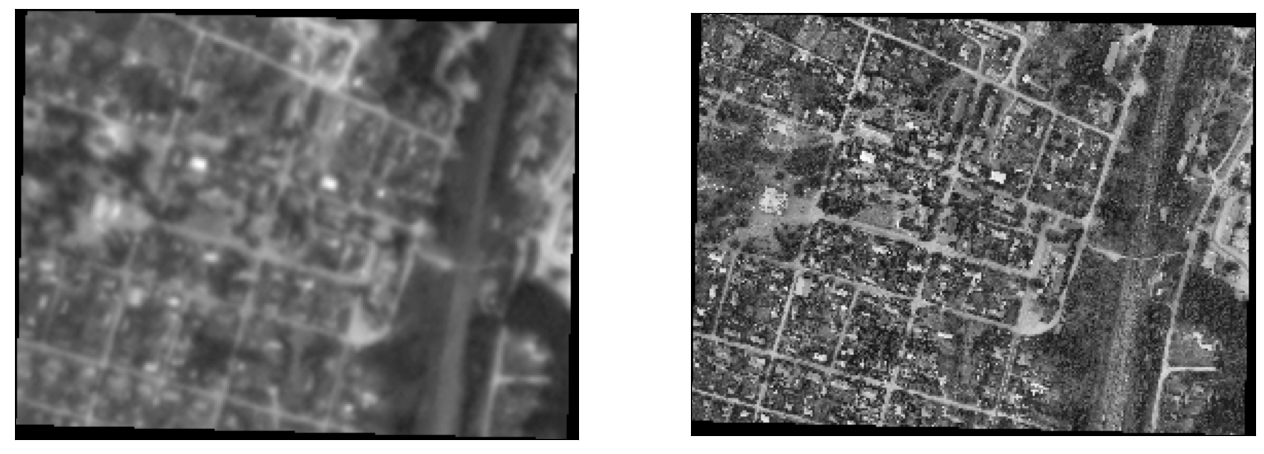

In [128]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
axs[0].imshow(imsat, cmap='gray')
axs[1].imshow(imuav, cmap='gray')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])


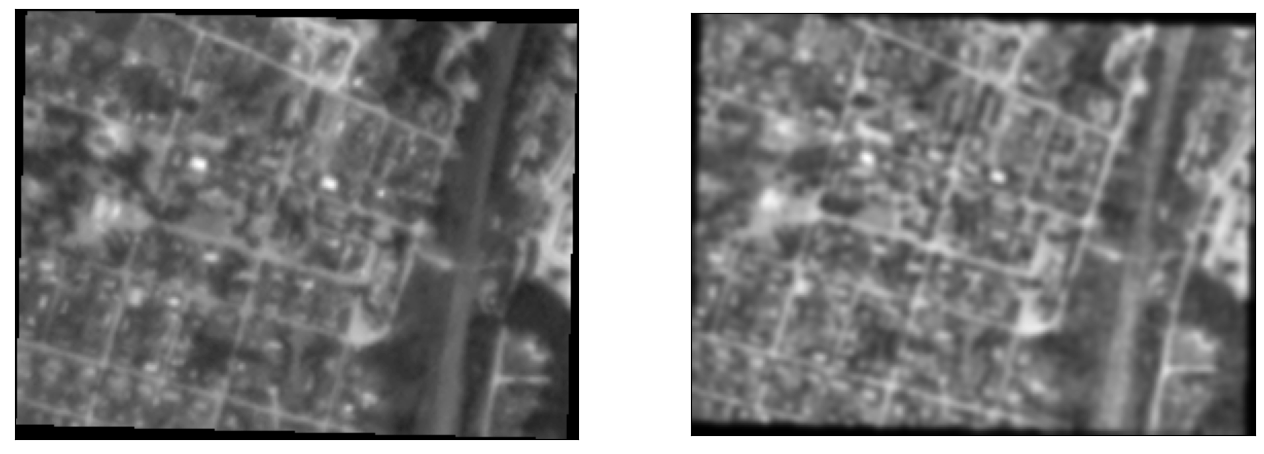

In [124]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6))
axs[0].imshow(imsat, cmap='gray')
axs[1].imshow(imuav, cmap='gray')
for ax in axs:
    ax.set_xticks([])
    ax.set_yticks([])
